# Neural Network

We chose the neural network regression for the prediction of the demand of bikesharing rental hourly, because it is a flexible model that can capture complex relationships between the input and target variable. The drawbacks of the model are the high computational requirements and that it is like a black box, which means there is no insight to the relationships between predictors and outcome. 
In order to execute the Neural Network model Keras and Tensorflow should be installed. Here we use the same procedure as in the workshop 9 *neural networks for regression in keras*.

In [81]:
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# supress versioning warnings of keras
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# import keras libraries

#from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

### Data preparation

First, we quickly prepare the needed data and variables we want to work with.

In [82]:
# Load data
df_bike_trips = pd.read_parquet("../../data/bike_trips_hourly_FINAL.parquet")
df_bike_trips.head(2)

,starting_trips,Most_Occuring_Starting_Neighborhood,min_temp,precip,hour,month,is_weekday,season,is_holiday
index,,,,,,,,,
2016-01-01 00:00:00,26.0,109,6.7,0.0,0,1,1,4,1
2016-01-01 01:00:00,39.0,112,7.2,0.0,1,1,1,4,1


#### Define X and Y

In [83]:
# Defining inputs and output
y = df_bike_trips["starting_trips"]
X = df_bike_trips.drop("starting_trips", axis=1)

#### Train the model on the training set

Now we create our training and test split, which we will use to train the model and adjust the hyperparameters. We also normalize our data with StandardScaler().

In [84]:
# Adjusted test_size to 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
# Normalizing training data
st_scaler = StandardScaler()
st_scaler.fit(X_train)

X_train_scaled = st_scaler.transform(X_train)

## Hyperparameters

Since neural networks have a lot of hyperparameters that can be used to adjust the performance of the model, we will outline some of them in the following lines.

- Loss function
- Optimizer
- Epochs
- Batch size
- Activation function
- Number of hidden layers
- Number of nodes per hidden layer

We will be using `loss=MSE`, `optimizer=adam`, `epochs=100` (until we have adjusted all hyperparameters), `batch size=32 (default)`. 

Later we determine the best activation function, number of hidden layers and number of nodes per hidden layer through a grid search. Until then we try out both relu, tanh and sigmoid activation functions, a large amount of hidden layers and a larger amount of nodes in the hidden layer.

### Initializing the ANN

First, we create a baseline model so we can compare our performance of models with unadjusted vs. adjusted hyperparameters.

Our first model contains a `single hidden layer`, in which the `number of nodes is equal to the amount of features` we use. We also only use `one output node`, the `mean squared error loss function` and the `relu activation function`. 

In [86]:
# Defining Baseline Model
model = Sequential(
    [Dense(X_train.shape[1], activation="relu", input_shape=[X_train.shape[1]]),
     Dense(1)])

In [87]:
# Compiling the ANN
model.compile(loss='mse',
             optimizer="adam",
             metrics=["mae", "mse"])

In [88]:
model.summary()

Model: "sequential_492"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2319 (Dense)           (None, 8)                 72        
_________________________________________________________________
dense_2320 (Dense)           (None, 1)                 9         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [89]:
epochs = 100

history = model.fit(X_train_scaled, y_train.values,
                   epochs=epochs, validation_split=0.2)

Epoch 1/100
163/163 [==============================] - 0s 1ms/step - loss: 10910.5536 - mae: 74.0390 - mse: 10910.5536 - val_loss: 11430.7861 - val_mae: 77.4382 - val_mse: 11430.7861
Epoch 2/100
163/163 [==============================] - 0s 652us/step - loss: 10991.6861 - mae: 74.2227 - mse: 10991.6861 - val_loss: 11164.0352 - val_mae: 76.1170 - val_mse: 11164.0352
Epoch 3/100
163/163 [==============================] - 0s 642us/step - loss: 10413.4338 - mae: 72.3449 - mse: 10413.4338 - val_loss: 10827.4375 - val_mae: 74.4637 - val_mse: 10827.4375
Epoch 4/100
163/163 [==============================] - 0s 641us/step - loss: 10514.0773 - mae: 71.8060 - mse: 10514.0773 - val_loss: 10338.9111 - val_mae: 72.2023 - val_mse: 10338.9111
Epoch 5/100
163/163 [==============================] - 0s 620us/step - loss: 10151.9507 - mae: 69.4481 - mse: 10151.9507 - val_loss: 9663.4756 - val_mae: 69.0996 - val_mse: 9663.4756
Epoch 6/100
163/163 [==============================] - 0s 627us/step - loss: 91

In [90]:
model.predict(X_train_scaled[:10])

array([[ -3.2794714],
       [  8.974809 ],
       [176.48651  ],
       [100.663536 ],
       [ 59.63904  ],
       [152.14981  ],
       [ 28.807926 ],
       [106.8771   ],
       [ 91.84122  ],
       [139.00104  ]], dtype=float32)

In [91]:
df_history = pd.DataFrame(history.history)
df_history

,loss,mae,mse,val_loss,val_mae,val_mse
0,11210.720703,75.243073,11210.720703,11430.786133,77.438210,11430.786133
1,10957.341797,73.953552,10957.341797,11164.035156,76.117035,11164.035156
2,10676.334961,72.540672,10676.334961,10827.437500,74.463707,10827.437500
3,10288.020508,70.635353,10288.020508,10338.911133,72.202263,10338.911133
4,9730.482422,67.998215,9730.482422,9663.475586,69.099586,9663.475586
...,...,...,...,...,...,...
95,2470.258301,34.375912,2470.258301,2366.908203,33.631287,2366.908203
96,2463.181152,34.453285,2463.181152,2359.632812,33.556602,2359.632812
97,2456.999268,34.263683,2456.999268,2353.406250,33.488762,2353.406250
98,2450.013916,34.215824,2450.013916,2346.544922,33.463074,2346.544922


In [92]:
df_root_metrics = df_history[["mse", "val_mse"]].apply(np.sqrt)
df_root_metrics.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)
df_root_metrics

,rmse,val_rmse
0,105.880691,106.914855
1,104.677322,105.659998
2,103.326352,104.054973
3,101.429880,101.680436
4,98.643208,98.302979
...,...,...
95,49.701693,48.650881
96,49.630446,48.576052
97,49.568128,48.511919
98,49.497615,48.441149


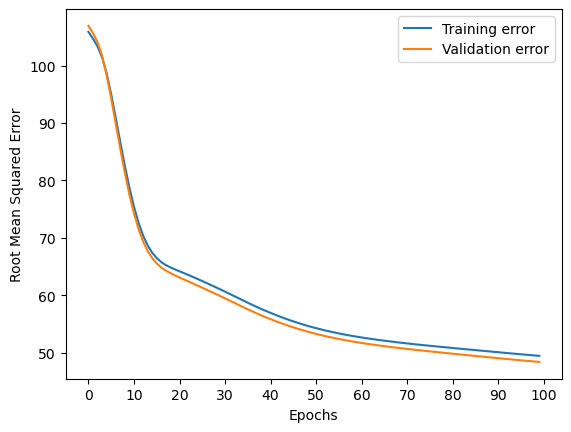

In [93]:
plt.Figure(figsize=(14,6), dpi=100)

plt.plot(df_root_metrics["rmse"], label = 'Training error')
plt.plot(df_root_metrics["val_rmse"], label = 'Validation error')

plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")

plt.xticks(np.arange(0, 100+1, 10.0))
plt.legend()

plt.show()

In [94]:
# Prediction on test set
X_test_scaled = st_scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)

In [95]:
# Performance
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"MAPE: {(mean_absolute_error(y_test, y_pred) / y_test.mean()) * 100:.2f}%")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")

MAE: 33.92
MSE: 2258.70
MAPE: 44.59%
RMSE: 47.53


## Alternative activation functions

Here we will try out the impact of three different activation functions on our model performance.

Our second model contains a `single hidden layer`, in which the `number of nodes is equal to the amount of features` we use. We also only use `one output node`, the `mean squared error loss function` and the `sigmoid activation function`. 

In [96]:
# Define sigmoid model
model_sigmoid = Sequential(
    [Dense(X_train.shape[1], activation="sigmoid", input_shape=[X_train.shape[1]]),
     Dense(1)])

In [97]:
model_sigmoid.compile(loss='mse',
             optimizer="adam",
             metrics=["mae", "mse"])

In [98]:
model_sigmoid.summary()

Model: "sequential_493"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2321 (Dense)           (None, 8)                 72        
_________________________________________________________________
dense_2322 (Dense)           (None, 1)                 9         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [99]:
history_sigmoid = model_sigmoid.fit(X_train_scaled, y_train.values,
                   epochs=epochs, validation_split=0.2)

Epoch 1/100
163/163 [==============================] - 0s 1ms/step - loss: 10855.8846 - mae: 74.0335 - mse: 10855.8846 - val_loss: 11389.6816 - val_mae: 77.1824 - val_mse: 11389.6816
Epoch 2/100
163/163 [==============================] - 0s 640us/step - loss: 11207.5129 - mae: 75.5062 - mse: 11207.5129 - val_loss: 11224.0020 - val_mae: 76.2430 - val_mse: 11224.0020
Epoch 3/100
163/163 [==============================] - 0s 621us/step - loss: 10773.0219 - mae: 73.6342 - mse: 10773.0219 - val_loss: 11045.0605 - val_mae: 75.2557 - val_mse: 11045.0605
Epoch 4/100
163/163 [==============================] - 0s 625us/step - loss: 10266.8653 - mae: 71.1451 - mse: 10266.8653 - val_loss: 10862.3867 - val_mae: 74.2612 - val_mse: 10862.3867
Epoch 5/100
163/163 [==============================] - 0s 623us/step - loss: 10503.1673 - mae: 71.1333 - mse: 10503.1673 - val_loss: 10677.4160 - val_mae: 73.2635 - val_mse: 10677.4160
Epoch 6/100
163/163 [==============================] - 0s 638us/step - loss: 

In [100]:
model_sigmoid.predict(X_train_scaled[:10])

array([[ 19.589914],
       [ 23.273853],
       [109.080734],
       [ 95.24836 ],
       [ 76.86741 ],
       [109.0963  ],
       [ 20.128975],
       [105.127975],
       [ 98.69788 ],
       [108.864365]], dtype=float32)

In [101]:
sigmoid_df_history = pd.DataFrame(history_sigmoid.history)
sigmoid_df_history

,loss,mae,mse,val_loss,val_mae,val_mse
0,11118.226562,74.770203,11118.226562,11389.681641,77.182388,11389.681641
1,10962.533203,73.827370,10962.533203,11224.001953,76.243034,11224.001953
2,10797.071289,72.878899,10797.071289,11045.060547,75.255722,11045.060547
3,10623.231445,71.910103,10623.231445,10862.386719,74.261192,10862.386719
4,10447.654297,70.934990,10447.654297,10677.416016,73.263451,10677.416016
...,...,...,...,...,...,...
95,3539.695801,40.487934,3539.695801,3382.840088,40.214260,3382.840088
96,3527.023926,40.479492,3527.023926,3369.332275,40.181839,3369.332275
97,3514.984375,40.460419,3514.984375,3356.812744,40.136551,3356.812744
98,3503.591553,40.431156,3503.591553,3344.888184,40.107967,3344.888184


In [102]:
sigmoid_df_root_metrics = sigmoid_df_history[["mse", "val_mse"]].apply(np.sqrt)
sigmoid_df_root_metrics.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)
sigmoid_df_root_metrics

,rmse,val_rmse
0,105.443001,106.722451
1,104.702117,105.943390
2,103.908957,105.095483
3,103.069062,104.222774
4,102.213768,103.331583
...,...,...
95,59.495343,58.162188
96,59.388753,58.045950
97,59.287304,57.938008
98,59.191144,57.835008


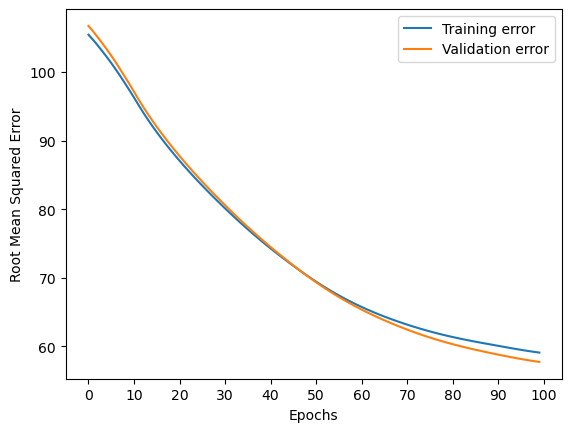

In [103]:
plt.Figure(figsize=(14,6), dpi=100)

plt.plot(sigmoid_df_root_metrics["rmse"], label = 'Training error')
plt.plot(sigmoid_df_root_metrics["val_rmse"], label = 'Validation error')

plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")

plt.xticks(np.arange(0, 100+1, 10.0))
plt.legend()

plt.show()

In [104]:
# Prediction on test set

X_test_scaled = st_scaler.transform(X_test)
y_pred = model_sigmoid.predict(X_test_scaled)

In [105]:
# Report regression performance on test set
# To-Do: look at metrics again

print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"MAPE: {(mean_absolute_error(y_test, y_pred) / y_test.mean()) * 100:.2f}%")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")
# print(f"R^2: { r2_score(y_test, y_pred):.2f}")

MAE: 40.03
MSE: 3361.82
MAPE: 52.62%
RMSE: 57.98


### tanh

Our third model contains a `single hidden layer`, in which the `number of nodes is equal to the amount of features` we use. We also only use `one output node`, the `mean squared error loss function` and the `tanh activation function`. 

In [106]:
# Define hyperbolic tangent (tanh) model
model_tanh = Sequential(
    [Dense(X_train.shape[1], activation="tanh", input_shape=[X_train.shape[1]]),
     Dense(1)])

In [107]:
model_tanh.compile(loss='mse',
             optimizer="adam",
             metrics=["mae", "mse"])

In [108]:
model_tanh.summary()

Model: "sequential_494"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2323 (Dense)           (None, 8)                 72        
_________________________________________________________________
dense_2324 (Dense)           (None, 1)                 9         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [109]:
history_tanh = model_tanh.fit(X_train_scaled, y_train.values,
                   epochs=epochs, validation_split=0.2)

Epoch 1/100
163/163 [==============================] - 0s 1ms/step - loss: 11355.4184 - mae: 74.4835 - mse: 11355.4184 - val_loss: 11386.4766 - val_mae: 77.3328 - val_mse: 11386.4766
Epoch 2/100
163/163 [==============================] - 0s 676us/step - loss: 10982.1210 - mae: 74.3395 - mse: 10982.1210 - val_loss: 11126.5645 - val_mae: 76.2819 - val_mse: 11126.5645
Epoch 3/100
163/163 [==============================] - 0s 647us/step - loss: 10546.1130 - mae: 72.8977 - mse: 10546.1130 - val_loss: 10839.6797 - val_mae: 74.9840 - val_mse: 10839.6797
Epoch 4/100
163/163 [==============================] - 0s 689us/step - loss: 9882.5034 - mae: 69.6260 - mse: 9882.5034 - val_loss: 10551.2334 - val_mae: 73.4983 - val_mse: 10551.2334
Epoch 5/100
163/163 [==============================] - 0s 651us/step - loss: 10169.4018 - mae: 70.3406 - mse: 10169.4018 - val_loss: 10272.6338 - val_mae: 71.8624 - val_mse: 10272.6338
Epoch 6/100
163/163 [==============================] - 0s 645us/step - loss: 10

In [110]:
model_tanh.predict(X_train_scaled[:10])

array([[ -2.4221506],
       [ 24.580349 ],
       [121.93775  ],
       [ 43.804684 ],
       [ 59.067886 ],
       [120.72979  ],
       [ 12.628377 ],
       [122.61278  ],
       [110.53489  ],
       [115.49414  ]], dtype=float32)

In [111]:
tanh_df_history = pd.DataFrame(history_tanh.history)
tanh_df_history

,loss,mae,mse,val_loss,val_mae,val_mse
0,11128.535156,74.791229,11128.535156,11386.476562,77.332764,11386.476562
1,10916.697266,73.940971,10916.697266,11126.564453,76.281906,11126.564453
2,10652.804688,72.774635,10652.804688,10839.679688,74.983963,10839.679688
3,10376.610352,71.410568,10376.610352,10551.233398,73.498260,10551.233398
4,10102.987305,69.839127,10102.987305,10272.633789,71.862427,10272.633789
...,...,...,...,...,...,...
95,2786.643555,32.277500,2786.643555,2681.687012,32.507889,2681.687012
96,2766.697021,32.230381,2766.697021,2661.152588,32.426014,2661.152588
97,2747.143555,32.168880,2747.143555,2641.017090,32.346306,2641.017090
98,2728.409180,32.131821,2728.409180,2621.515137,32.290192,2621.515137


In [112]:
tanh_df_root_metrics = tanh_df_history[["mse", "val_mse"]].apply(np.sqrt)
tanh_df_root_metrics.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)
tanh_df_root_metrics

,rmse,val_rmse
0,105.491872,106.707434
1,104.483000,105.482532
2,103.212425,104.113782
3,101.865649,102.719197
4,100.513618,101.354002
...,...,...
95,52.788669,51.785008
96,52.599401,51.586360
97,52.413200,51.390827
98,52.234176,51.200734


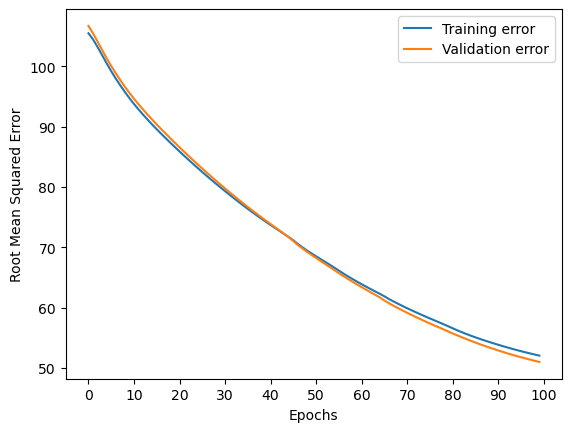

In [113]:
plt.Figure(figsize=(14,6), dpi=100)

plt.plot(tanh_df_root_metrics["rmse"], label = 'Training error')
plt.plot(tanh_df_root_metrics["val_rmse"], label = 'Validation error')

plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")

plt.xticks(np.arange(0, 100+1, 10.0))
plt.legend()

plt.show()

In [114]:
# Prediction on test set

X_test_scaled = st_scaler.transform(X_test)
y_pred = model_tanh.predict(X_test_scaled)

In [115]:
# Report regression performance on test set

print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"MAPE: {(mean_absolute_error(y_test, y_pred) / y_test.mean()) * 100:.2f}%")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")

MAE: 32.30
MSE: 2595.22
MAPE: 42.45%
RMSE: 50.94


Seeing the performance of our baseline model with the relu activation function vs. sigmoid and hyperbolic tangent activation functions, we determined that the sigmoid activation function does not perform well enough for our purposes. 

While the hyperbolic tangent activation function performs slightly better against the relu activation function in this instance, we learnt about the vanishing gradient problem while working on the project. Therefore, we decided to keep considering both activation functions later on in our grid search.

## Number of hidden layers

Now we want to try and see the impact on performance when we change the number of hidden layers we use in our neural network. 

Our fourth model contains a `3 hidden layers`, in which the `number of nodes is equal to the amount of features` we use. We also only use `one output node`, the `mean squared error loss function` and the `relu activation function`. 

In [116]:
# Define model with more hidden layers
model_mlayers = Sequential(
    [Dense(X_train.shape[1], activation="relu", input_shape=[X_train.shape[1]]),
     Dense(X_train.shape[1], activation="relu"),
     Dense(X_train.shape[1], activation="relu"),
     Dense(1)])

In [117]:
model_mlayers.compile(loss='mse',
             optimizer="adam",
             metrics=["mae", "mse"])

In [118]:
model_mlayers.summary()

Model: "sequential_495"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2325 (Dense)           (None, 8)                 72        
_________________________________________________________________
dense_2326 (Dense)           (None, 8)                 72        
_________________________________________________________________
dense_2327 (Dense)           (None, 8)                 72        
_________________________________________________________________
dense_2328 (Dense)           (None, 1)                 9         
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


In [119]:
history_mlayers = model_mlayers.fit(X_train_scaled, y_train.values,
                   epochs=epochs, validation_split=0.2)

Epoch 1/100
163/163 [==============================] - 0s 1ms/step - loss: 11220.0328 - mae: 75.2320 - mse: 11220.0328 - val_loss: 10580.9170 - val_mae: 72.5399 - val_mse: 10580.9170
Epoch 2/100
163/163 [==============================] - 0s 860us/step - loss: 8827.9661 - mae: 64.3921 - mse: 8827.9661 - val_loss: 4945.3994 - val_mae: 48.9978 - val_mse: 4945.3994
Epoch 3/100
163/163 [==============================] - 0s 837us/step - loss: 4508.2475 - mae: 47.4782 - mse: 4508.2475 - val_loss: 3907.0503 - val_mae: 45.8744 - val_mse: 3907.0503
Epoch 4/100
163/163 [==============================] - 0s 793us/step - loss: 3946.3178 - mae: 45.7681 - mse: 3946.3178 - val_loss: 3874.7512 - val_mae: 45.5381 - val_mse: 3874.7512
Epoch 5/100
163/163 [==============================] - 0s 888us/step - loss: 3815.7500 - mae: 45.2548 - mse: 3815.7500 - val_loss: 3862.1685 - val_mae: 45.3196 - val_mse: 3862.1685
Epoch 6/100
163/163 [==============================] - 0s 750us/step - loss: 4143.8374 - mae:

In [120]:
model_mlayers.predict(X_train_scaled[:10])

array([[ -0.9729234],
       [ 19.56104  ],
       [219.55742  ],
       [101.6325   ],
       [ 78.934875 ],
       [171.56567  ],
       [ -2.0602953],
       [133.58353  ],
       [134.92058  ],
       [135.46786  ]], dtype=float32)

In [121]:
mlayers_df_history = pd.DataFrame(history_mlayers.history)
mlayers_df_history

,loss,mae,mse,val_loss,val_mae,val_mse
0,10922.598633,73.489105,10922.598633,10580.916992,72.539940,10580.916992
1,7880.708008,59.605740,7880.708008,4945.399414,48.997814,4945.399414
2,4175.083496,46.552971,4175.083496,3907.050293,45.874386,3907.050293
3,3990.868164,45.985359,3990.868164,3874.751221,45.538147,3874.751221
4,3957.106445,45.746323,3957.106445,3862.168457,45.319630,3862.168457
...,...,...,...,...,...,...
95,1635.109985,26.230284,1635.109985,1568.327026,25.733967,1568.327026
96,1632.921143,26.040894,1632.921143,1568.275635,25.908716,1568.275635
97,1623.781250,26.028290,1623.781250,1553.774902,25.680357,1553.774902
98,1617.994751,25.923649,1617.994751,1549.181763,25.696873,1549.181763


In [122]:
mlayers_df_root_metrics = mlayers_df_history[["mse", "val_mse"]].apply(np.sqrt)
mlayers_df_root_metrics.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)
mlayers_df_root_metrics

,rmse,val_rmse
0,104.511237,102.863584
1,88.773352,70.323534
2,64.614886,62.506402
3,63.173318,62.247500
4,62.905536,62.146347
...,...,...
95,40.436493,39.602109
96,40.409419,39.601460
97,40.296169,39.417952
98,40.224305,39.359646


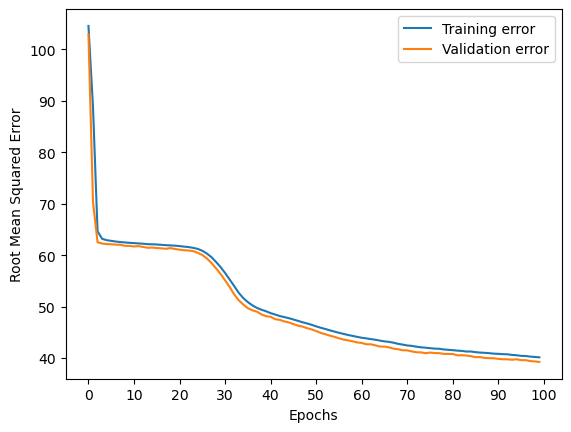

In [123]:
plt.Figure(figsize=(14,6), dpi=100)

plt.plot(mlayers_df_root_metrics["rmse"], label = 'Training error')
plt.plot(mlayers_df_root_metrics["val_rmse"], label = 'Validation error')

plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")

plt.xticks(np.arange(0, 100+1, 10.0))
plt.legend()

plt.show()

In [124]:
# Prediction on test set

X_test_scaled = st_scaler.transform(X_test)
y_pred = model_mlayers.predict(X_test_scaled)

In [125]:
# Report regression performance on test set

print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"MAPE: {(mean_absolute_error(y_test, y_pred) / y_test.mean()) * 100:.2f}%")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")

MAE: 26.66
MSE: 1537.05
MAPE: 35.04%
RMSE: 39.21


## More nodes

Now we want to try and see the impact on performance when we change the number of nodes within the hidden layer.

Our fifth model contains a `single hidden layers`, in which the `number of nodes =(number of features)*2` we use. We also only use `one output node`, the `mean squared error loss function` and the `relu activation function`. 

In [126]:
# Define model with more nodes in hidden layer
model_mnodes = Sequential(
    [Dense(X_train.shape[1]*2, activation="relu", input_shape=[X_train.shape[1]]),
     Dense(1)])

In [127]:
model_mnodes.compile(loss='mse',
             optimizer="adam",
             metrics=["mae", "mse"])

In [128]:
model_mnodes.summary()

Model: "sequential_496"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2329 (Dense)           (None, 16)                144       
_________________________________________________________________
dense_2330 (Dense)           (None, 1)                 17        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [129]:
history_mnodes = model_mnodes.fit(X_train_scaled, y_train.values,
                   epochs=epochs, validation_split=0.2)

Epoch 1/100
163/163 [==============================] - 0s 1ms/step - loss: 11439.5686 - mae: 75.0411 - mse: 11439.5686 - val_loss: 11243.9072 - val_mae: 76.4012 - val_mse: 11243.9072
Epoch 2/100
163/163 [==============================] - 0s 688us/step - loss: 10670.4942 - mae: 72.2650 - mse: 10670.4942 - val_loss: 10678.9141 - val_mae: 73.5416 - val_mse: 10678.9141
Epoch 3/100
163/163 [==============================] - 0s 650us/step - loss: 10026.4513 - mae: 68.8433 - mse: 10026.4513 - val_loss: 9735.7422 - val_mae: 69.0325 - val_mse: 9735.7422
Epoch 4/100
163/163 [==============================] - 0s 653us/step - loss: 8814.7146 - mae: 63.1640 - mse: 8814.7146 - val_loss: 8523.6729 - val_mae: 63.3360 - val_mse: 8523.6729
Epoch 5/100
163/163 [==============================] - 0s 647us/step - loss: 8257.6356 - mae: 60.2077 - mse: 8257.6356 - val_loss: 7209.3413 - val_mae: 57.3894 - val_mse: 7209.3413
Epoch 6/100
163/163 [==============================] - 0s 650us/step - loss: 6447.2421 

In [130]:
model_mnodes.predict(X_train_scaled[:10])

array([[ -4.6041155],
       [ 11.485114 ],
       [180.62532  ],
       [ 97.12302  ],
       [ 63.497066 ],
       [148.6893   ],
       [ 26.249725 ],
       [102.45785  ],
       [ 91.39805  ],
       [139.83652  ]], dtype=float32)

In [131]:
mnodes_df_history = pd.DataFrame(history_mnodes.history)
mnodes_df_history

,loss,mae,mse,val_loss,val_mae,val_mse
0,11062.605469,74.429947,11062.605469,11243.907227,76.401230,11243.907227
1,10663.727539,72.275528,10663.727539,10678.914062,73.541634,10678.914062
2,9940.491211,68.684570,9940.491211,9735.742188,69.032463,9735.742188
3,8895.140625,63.737782,8895.140625,8523.672852,63.336044,8523.672852
4,7674.472168,57.997410,7674.472168,7209.341309,57.389359,7209.341309
...,...,...,...,...,...,...
95,2544.738770,35.034992,2544.738770,2483.774414,34.464867,2483.774414
96,2539.238281,34.962242,2539.238281,2479.397949,34.360260,2479.397949
97,2533.996582,34.862747,2533.996582,2474.313721,34.323719,2474.313721
98,2528.136230,34.825378,2528.136230,2468.812988,34.317657,2468.812988


In [132]:
mnodes_df_root_metrics = mnodes_df_history[["mse", "val_mse"]].apply(np.sqrt)
mnodes_df_root_metrics.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)
mnodes_df_root_metrics

,rmse,val_rmse
0,105.178921,106.037292
1,103.265326,103.338831
2,99.702012,98.669865
3,94.314053,92.323739
4,87.604065,84.907840
...,...,...
95,50.445404,49.837480
96,50.390855,49.793553
97,50.338818,49.742474
98,50.280575,49.687151


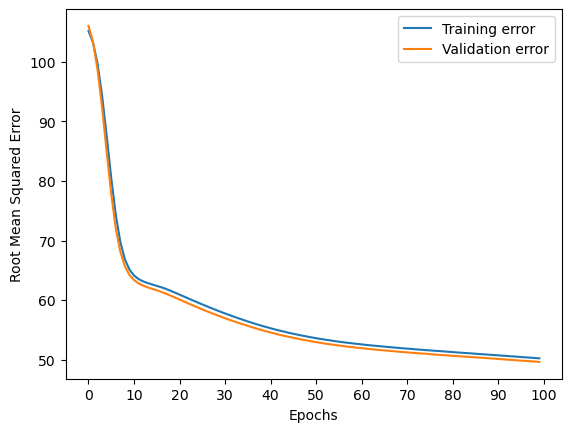

In [133]:
plt.Figure(figsize=(14,6), dpi=100)

plt.plot(mnodes_df_root_metrics["rmse"], label = 'Training error')
plt.plot(mnodes_df_root_metrics["val_rmse"], label = 'Validation error')

plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")

plt.xticks(np.arange(0, 100+1, 10.0))
plt.legend()

plt.show()

In [134]:
# Prediction on test set

X_test_scaled = st_scaler.transform(X_test)
y_pred = model_mnodes.predict(X_test_scaled)

In [135]:
# Report regression performance on test set

print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"MAPE: {(mean_absolute_error(y_test, y_pred) / y_test.mean()) * 100:.2f}%")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")

MAE: 34.61
MSE: 2350.03
MAPE: 45.49%
RMSE: 48.48


In both instances that we looked at, the adjusting of the number of hidden layers and number of nodes within the hidden layers positively impacted the performance of the model. 

However, one should be aware that due to the stochastical nature of neural networks, the performance measures can be different each time the models are trained.

## Gridsearch for optimal hyperparameters

Now we want to perform a [grid search](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/) on our three chosen hyperparameters: `number of hidden layers`, `number of nodes in hidden layers`, and `activation functions`. We do this because we want to find the best combination of hyperparameters for our model performance.

In [136]:
# https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

# Create gridsearch model function because we had issues running the grid search when manually creating the model
def gs_model_create( n_nodes, n_hidden_layers, activation, loss='mse'):
    gs_model= Sequential()
    gs_model.add(Dense(n_nodes, activation=activation, input_shape=[X_train.shape[1]]))
    
    #add hidden layers if given parameter
    for _ in range(n_hidden_layers - 1):
        model.add(Dense(n_nodes, activation=activation))
    
    gs_model.add(Dense(1))
    gs_model.compile(loss=loss)
    return gs_model

In [137]:
#create parameter grid
parameters = { 
    'activation': ['relu', 'tanh'],
    'n_hidden_layers': [1, 2, 4, 8],
    'n_nodes': [1, X_train.shape[1], X_train.shape[1] * 2, X_train.shape[1] * 4]
    }

# grid search without taking average below (faster but best_parameter result changes often when running)
# grid_searchNEW = GridSearchCV(estimator = KerasRegressor(gs_model_create),
#                            param_grid = parameters,
#                            cv = 3)

We decided to take the average of the result of the gridsearch because the best parameters changed multiple times. 

In [138]:
# number of runs
n_runs = 5

# list to store the results of the runs
results = []

# run the grid search multiple times
for i in range(n_runs):
    grid_searchNEW = GridSearchCV(estimator = KerasRegressor(gs_model_create),
                           param_grid = parameters, return_train_score=True, 
                           cv = 3)
    grid_searchNEW.fit(X_train, y_train, verbose=1)
    results.append(grid_searchNEW.cv_results_)

204/204 [==============================] - 0s 445us/step - loss: 8405.1410


In [139]:
# average the results
average_scores = {}
for score in ['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score']:
    average_scores[score] = np.mean([result[score] for result in results], axis=0)

In [140]:
# best parameters and best score
best_params = results[0]['params'][np.argmax(average_scores['mean_test_score'])]
best_score = np.max(average_scores['mean_test_score'])
print("Best parameters: ", best_params)

Best parameters:  {'activation': 'relu', 'n_hidden_layers': 1, 'n_nodes': 32}


Through the grid-search we found that `relu, 4, 32` is the best combination of hyperparameters for performance. 

Again, be aware that the results of the gridsearch for neural networks is random because of gradient descent. The "best" combination of hyperparameters can change each run. We tried to stabilize the best parameter result by averaging it.

Now we will use the combination of hyperparameters above to retrain our NN with a larger number of epochs to see the impact on performance.

Our sixth model contains a `four hidden layers`, in which the `number of nodes =(number of features)*4` we use. We also only use `one output node`, the `mean squared error loss function` and the `relu activation function`. We use `epochs=500`.

In [141]:
large_epoch_model = Sequential(
    [Dense(X_train.shape[1]*4, activation="relu", input_shape=[X_train.shape[1]]),
     Dense(X_train.shape[1]*4, activation="relu"),
     Dense(X_train.shape[1]*4, activation="relu"),
     Dense(X_train.shape[1]*4, activation="relu"),
     Dense(1)])

In [142]:
large_epoch_model.compile(loss='mse',
             optimizer="adam",
             metrics=["mae", "mse"])

In [143]:
large_epoch_model.summary()

Model: "sequential_982"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4634 (Dense)           (None, 32)                288       
_________________________________________________________________
dense_4635 (Dense)           (None, 32)                1056      
_________________________________________________________________
dense_4636 (Dense)           (None, 32)                1056      
_________________________________________________________________
dense_4637 (Dense)           (None, 32)                1056      
_________________________________________________________________
dense_4638 (Dense)           (None, 1)                 33        
Total params: 3,489
Trainable params: 3,489
Non-trainable params: 0
_________________________________________________________________


In [144]:
#we use epochs=500
history_large_epoch_model = large_epoch_model.fit(X_train_scaled, y_train.values,
                   epochs=500, validation_split=0.2)

Epoch 1/500
163/163 [==============================] - 0s 1ms/step - loss: 9708.7918 - mae: 69.5597 - mse: 9708.7918 - val_loss: 4080.8442 - val_mae: 47.4656 - val_mse: 4080.8442
Epoch 2/500
163/163 [==============================] - 0s 1ms/step - loss: 3949.1292 - mae: 45.3799 - mse: 3949.1292 - val_loss: 3520.5723 - val_mae: 42.4389 - val_mse: 3520.5723
Epoch 3/500
163/163 [==============================] - 0s 875us/step - loss: 3338.7398 - mae: 40.4018 - mse: 3338.7398 - val_loss: 2814.4583 - val_mae: 36.7276 - val_mse: 2814.4583
Epoch 4/500
163/163 [==============================] - 0s 923us/step - loss: 2840.6821 - mae: 36.1216 - mse: 2840.6821 - val_loss: 2316.3716 - val_mae: 32.5513 - val_mse: 2316.3716
Epoch 5/500
163/163 [==============================] - 0s 903us/step - loss: 2432.4920 - mae: 32.5737 - mse: 2432.4920 - val_loss: 2131.1792 - val_mae: 30.4196 - val_mse: 2131.1792
Epoch 6/500
163/163 [==============================] - 0s 824us/step - loss: 2224.0357 - mae: 30.36

In [145]:
large_epoch_model.predict(X_train_scaled[:10])

array([[  8.7326765],
       [ 17.644075 ],
       [253.14703  ],
       [ 99.15992  ],
       [ 77.988914 ],
       [200.27531  ],
       [  9.242989 ],
       [151.21275  ],
       [134.42494  ],
       [114.25178  ]], dtype=float32)

In [146]:
large_epoch_model_df_history = pd.DataFrame(history_large_epoch_model.history)
large_epoch_model_df_history

,loss,mae,mse,val_loss,val_mae,val_mse
0,7539.823242,61.263206,7539.823242,4080.844238,47.465622,4080.844238
1,3863.022949,44.795849,3863.022949,3520.572266,42.438881,3520.572266
2,3272.004639,39.674255,3272.004639,2814.458252,36.727642,2814.458252
3,2630.427246,34.355358,2630.427246,2316.371582,32.551258,2316.371582
4,2312.581055,31.337896,2312.581055,2131.179199,30.419621,2131.179199
...,...,...,...,...,...,...
495,469.577332,13.262811,469.577332,779.283875,16.529022,779.283875
496,481.073151,13.463227,481.073151,848.671326,17.702269,848.671326
497,477.161102,13.396813,477.161102,879.361633,17.787411,879.361633
498,477.548798,13.331732,477.548798,751.453247,16.401747,751.453247


In [147]:
large_epoch_model_df_root_metrics = large_epoch_model_df_history[["mse", "val_mse"]].apply(np.sqrt)
large_epoch_model_df_root_metrics.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)
large_epoch_model_df_root_metrics

,rmse,val_rmse
0,86.832156,63.881486
1,62.153222,59.334410
2,57.201439,53.051468
3,51.287691,48.128698
4,48.089303,46.164696
...,...,...
495,21.669733,27.915656
496,21.933380,29.131964
497,21.844018,29.654032
498,21.852890,27.412648


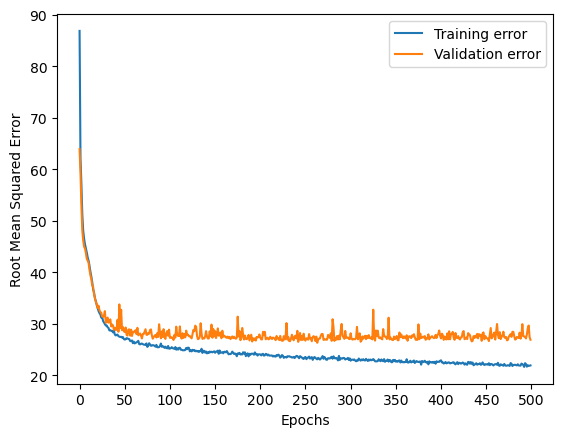

In [148]:
plt.Figure(figsize=(14,6), dpi=100)

plt.plot(large_epoch_model_df_root_metrics["rmse"], label = 'Training error')
plt.plot(large_epoch_model_df_root_metrics["val_rmse"], label = 'Validation error')

plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")

plt.xticks(np.arange(0, 500+1, 50.0))
plt.legend()

plt.show()

In [149]:
# Prediction on test set
X_test_scaled = st_scaler.transform(X_test)
y_pred = large_epoch_model.predict(X_test_scaled)

In [150]:
#Performance
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"MAPE: {(mean_absolute_error(y_test, y_pred) / y_test.mean()) * 100:.2f}%")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")

MAE: 16.26
MSE: 702.80
MAPE: 21.37%
RMSE: 26.51


We can see that the model is already performing much better compared to our previous models.

## Dropout layers
However, we believe that the model is overfitting a bit, despite our efforts. Therefore we will add dropout layers to the same neural network in the next step.

In [151]:
large_drop_model = Sequential(
    [Dense(X_train.shape[1]*4, activation="relu", input_shape=[X_train.shape[1]]),
     Dense(X_train.shape[1]*4, activation="relu"),
     Dropout(0.2),
     Dense(X_train.shape[1]*4, activation="relu"),
     Dropout(0.2),
     Dense(X_train.shape[1]*4, activation="relu"),
     Dropout(0.2),
     Dense(1)])

In [152]:
large_drop_model.compile(loss='mse',
             optimizer="adam",
             metrics=["mae", "mse"])

In [153]:
large_drop_model.summary()

Model: "sequential_983"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4639 (Dense)           (None, 32)                288       
_________________________________________________________________
dense_4640 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4641 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4642 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)             

In [154]:
history_large_drop_model = large_drop_model.fit(X_train_scaled, y_train.values,
                   epochs=500, validation_split=0.2)

Epoch 1/500
163/163 [==============================] - 1s 1ms/step - loss: 9317.6132 - mae: 67.5520 - mse: 9317.6132 - val_loss: 4007.8701 - val_mae: 46.4030 - val_mse: 4007.8701
Epoch 2/500
163/163 [==============================] - 0s 887us/step - loss: 4186.4311 - mae: 46.4946 - mse: 4186.4311 - val_loss: 3637.1716 - val_mae: 41.2122 - val_mse: 3637.1716
Epoch 3/500
163/163 [==============================] - 0s 871us/step - loss: 3596.2125 - mae: 41.6529 - mse: 3596.2125 - val_loss: 2934.5623 - val_mae: 37.7552 - val_mse: 2934.5623
Epoch 4/500
163/163 [==============================] - 0s 886us/step - loss: 2864.4684 - mae: 36.7099 - mse: 2864.4684 - val_loss: 2450.0237 - val_mae: 33.6008 - val_mse: 2450.0237
Epoch 5/500
163/163 [==============================] - 0s 893us/step - loss: 2981.2828 - mae: 35.4822 - mse: 2981.2828 - val_loss: 2193.0393 - val_mae: 30.2687 - val_mse: 2193.0393
Epoch 6/500
163/163 [==============================] - 0s 880us/step - loss: 2414.4106 - mae: 32.

In [155]:
large_drop_model.predict(X_train_scaled[:10])

array([[ 11.931454],
       [ 12.396567],
       [226.76648 ],
       [ 76.52583 ],
       [ 78.27212 ],
       [173.58113 ],
       [  9.400768],
       [145.8555  ],
       [135.95233 ],
       [106.59944 ]], dtype=float32)

In [156]:
large_drop_model_df_history = pd.DataFrame(history_large_drop_model.history)
large_drop_model_df_history

,loss,mae,mse,val_loss,val_mae,val_mse
0,7458.611816,60.196907,7458.611816,4007.870117,46.402973,4007.870117
1,4118.537598,45.195469,4118.537598,3637.171631,41.212200,3637.171631
2,3590.228516,41.132656,3590.228516,2934.562256,37.755157,2934.562256
3,3107.037354,37.529942,3107.037354,2450.023682,33.600807,2450.023682
4,2714.855957,34.320007,2714.855957,2193.039307,30.268717,2193.039307
...,...,...,...,...,...,...
495,823.618958,18.270929,823.618958,728.586182,17.352156,728.586182
496,793.124573,18.084520,793.124573,744.238464,17.255594,744.238464
497,828.000671,18.273525,828.000671,778.470093,17.735270,778.470093
498,810.554932,18.299318,810.554932,741.705322,17.012232,741.705322


In [157]:
large_drop_model_df_root_metrics = large_drop_model_df_history[["mse", "val_mse"]].apply(np.sqrt)
large_drop_model_df_root_metrics.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)
large_drop_model_df_root_metrics

,rmse,val_rmse
0,86.363255,63.307741
1,64.175833,60.308968
2,59.918516,54.171600
3,55.740805,49.497714
4,52.104280,46.829898
...,...,...
495,28.698762,26.992336
496,28.162467,27.280734
497,28.775001,27.901077
498,28.470246,27.234267


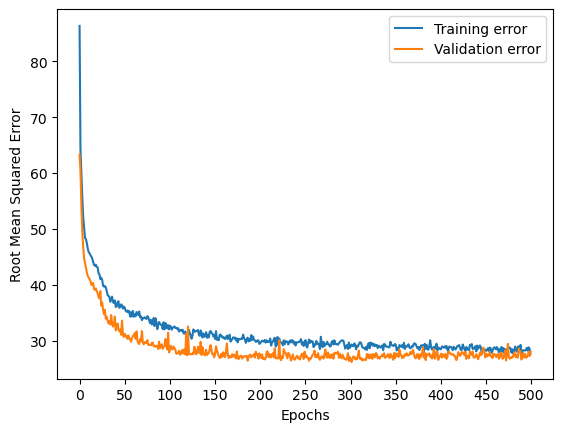

In [158]:
plt.Figure(figsize=(14,6), dpi=100)

plt.plot(large_drop_model_df_root_metrics["rmse"], label = 'Training error')
plt.plot(large_drop_model_df_root_metrics["val_rmse"], label = 'Validation error')

plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")

# plt.xlim([0, epochs])
# plt.xticks(range(2,10))
plt.xticks(np.arange(0, 500+1, 50.0))
plt.legend()

plt.show()

In [159]:
# Prediction on test set
X_test_scaled = st_scaler.transform(X_test)
y_pred = large_drop_model.predict(X_test_scaled)

In [161]:
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"MAPE: {(mean_absolute_error(y_test, y_pred) / y_test.mean()) * 100:.2f}%")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")

MAE: 17.85
MSE: 786.80
MAPE: 23.46%
RMSE: 28.05


We tried to implement the dropout layers in order to improve performance, but our research showed that it is less necessary to use dropout layers when using the relu activation function. We wanted to experiment whether they would significantly impact the performance regardless. We found that using dropout layers did not impact the performance positively with each run due to the stochastical nature of neural networks but we kept our result in the notebook to show our efforts.

Outlook: The performance could be improved by adding more options as hyperparameters, e.g. batch size. This would increase the computational requirements by a lot. To improve our computational power we could adjust the Neural Network to be trained on our GPU or on remote servers with more computational power. 